# Model Serving

*This Python notebook covers the usage of endpoints for obtaining inferences and also includes guidance on utilizing canary deployment techniques*

*In the context of model deployment, canary deployment is a highly recommended method to upgrade an existing baseline model to a newer version. This involves directing a controlled portion of live traffic to the upgraded endpoint and performing A/B testing to determine if the new version performs better than the baseline on live data. The canary deployment process typically begins by diverting a small percentage of live traffic, ranging from 1% to 5%, to the upgraded version. If there are no errors, traffic is gradually increased, thus minimizing the risk of potential issues during the transition. This approach ensures a smooth and cautious transition to the new version while maintaining a high degree of safety.*

*The German credit dataset is a dataset commonly used in credit risk analysis*

* Age: the age of the applicant in years
* Credit amount: the amount of credit applied
* Duration: the duration of the credit in months
* Risk: the risk associated with the credit, with two possible values: "0" or "1" 
* Sex: the gender of the applicant, with two possible values: "male" or "female"
* Job: the type of job of the applicant
* Housing: the type of housing of the applicant, with three possible values: "rent", "own", or "free" 
* Purpose: the purpose of the credit

### Connect to the workspace

First, we'll need to connect to your Azure Machine Learning workspace. The Azure Machine Learning workspace is the top-level resource for the service. It provides you with a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

We're using DefaultAzureCredential to get access to the workspace. This credential should be capable of handling most Azure SDK authentication scenarios.

In [1]:
# Handle to the workspace
from azure.ai.ml import MLClient

# Authentication package
from azure.identity import DefaultAzureCredential

credential = DefaultAzureCredential()

Next, get a handle to the workspace by providing your Subscription ID, Resource Group name, and workspace name. To find these parameters:

* Look in the upper-right corner of the Azure Machine Learning studio toolbar for your workspace name.
* Select your workspace name to show your Resource Group and Subscription ID.
* Copy the values for Resource Group and Subscription ID into the code.

In [2]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="0d86e202-dfd4-4954-bdc4-ba82f5e270bd", #Provide your subscription ID as shown in the above screenshot
    resource_group_name="GLMLPOs", #Provide your Resource Group as shown in the above screenshot
    workspace_name="azureml",
)

### Create a compute resource to run the job

Azure Machine Learning needs a compute resource to run a job. This resource can be single or multi-node machines with Linux or Windows OS, or a specific compute fabric like Spark.

We only need a basic cluster for this task; thus, we'll pick a Standard_D2_v3 model with 2 CPU cores and 7 GB RAM to create an Azure Machine Learning compute.

In [3]:
from azure.ai.ml.entities import AmlCompute

# Name assigned to the compute cluster
cpu_compute_target = "cpu-cluster-model-serving"

try:
    # let's see if the compute target already exists
    cpu_cluster = ml_client.compute.get(cpu_compute_target)
    print(
        f"You already have a cluster named {cpu_compute_target}, we'll reuse it as is."
    )

except Exception:
    print("Creating a new cpu compute target...")

    # Let's create the Azure ML compute object with the intended parameters
    cpu_cluster = AmlCompute(
        name=cpu_compute_target,
        # Azure ML Compute is the on-demand VM service
        type="amlcompute",
        # VM Family
        size="STANDARD_D2_V3",
        # Minimum running nodes when there is no job running
        min_instances=0,
        # Nodes in cluster
        max_instances=1,
        # How many seconds will the node running after the job termination
        idle_time_before_scale_down=180,
        # Dedicated or LowPriority. The latter is cheaper but there is a chance of job termination
        tier="Dedicated",
    )

    # Now, we pass the object to MLClient's create_or_update method
    cpu_cluster = ml_client.compute.begin_create_or_update(cpu_cluster).result()

print(
    f"AMLCompute with name {cpu_cluster.name} is created, the compute size is {cpu_cluster.size}"
)

Creating a new cpu compute target...
AMLCompute with name cpu-cluster-model-serving is created, the compute size is STANDARD_D2_V3


### Create a job environment

To run an Azure Machine Learning job, you'll need an environment. It encapsulates the dependencies (such as software runtime and libraries) needed to run our machine learning training script on our compute resource. This environment is similar to a Python environment on our local machine.

We'll create a custom environment for our jobs, using a Conda YAML file.

#### Create a custom environment

To create your custom environment, we'll define your Conda dependencies in a YAML file. First, create a directory for storing the file. We've named the directory env.

In [4]:
import os

## Set the name of the directory we want to create
dependencies_dir = "./env"

# # The os.makedirs() function creates a directory
# exist_ok=True means that the function will not raise an exception if the directory already exists
os.makedirs(dependencies_dir, exist_ok=True)

Then, create the file in the dependencies directory. In this example, we've named the file conda.yml.

In [5]:
%%writefile {dependencies_dir}/conda.yaml
name: sklearn-env
channels:
  - conda-forge
dependencies:
  - python=3.8
  - pip=21.2.4
  - scikit-learn=0.23.2
  - scipy=1.7.1
  - pip:  
    - mlflow==2.3
    - azureml-mlflow==1.51.0
    - azureml-inference-server-http
    - azureml-core==1.49.0
    - cloudpickle==1.6.0

Overwriting ./env/conda.yaml


The specification contains some usual packages (such as numpy and pip) that you'll use in our job.

Next, use the YAML file to create and register this custom environment in our workspace. The environment will be packaged into a Docker container at runtime.

In [6]:
# Import the Environment class from the azure.ai.ml.entities module
from azure.ai.ml.entities import Environment


# Set the name of the custom environment we want to create
custom_env_name = "machine_learning_model_serving"

# Create an Environment object with the specified properties
job_env = Environment(
    name=custom_env_name,
    description="Custom environment for machine learning task",
    conda_file=os.path.join(dependencies_dir, "conda.yaml"),
    image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04:latest",
)
job_env = ml_client.environments.create_or_update(job_env)

# Print out some information about the registered environment
print(
    f"Environment with name {job_env.name} is registered to workspace, the environment version is {job_env.version}"
)

Environment with name machine_learning_model_serving is registered to workspace, the environment version is 6


### Configure and submit your training job

In [7]:
# To use the training script, first create a directory where you will store the file.
import os

src_dir = "./src"
os.makedirs(src_dir, exist_ok=True)

**Next, create the script file in the source directory. Description of the script is as follows:**

* The scripts defines a command-line interface for training a Decision Tree model and gradient boosting model on a given input dataset, logs the results to MLflow, saves the trained model as an MLflow artifact, and registers it with the model registry.


* The script first imports necessary libraries for building and evaluating the Decision Tree model, as well as libraries for logging the model and its parameters and metrics to MLflow.


* Next, the script defines a main() function that sets up the command-line interface using the argparse library. The function reads in the input dataset from a specified path, sets the model parameters based on user input, and trains the model using the training data. The script then evaluates the trained model on a holdout test set and logs the resulting accuracy and confusion matrix to MLflow.


* Finally, the script registers the trained model with the MLflow model registry by logging it as an MLflow artifact and then saving it to disk using mlflow.sklearn.log_model() and mlflow.sklearn.save_model(), respectively. The registered model can be deployed and served using the MLflow model serving capabilities.

#### First Model : Gradient Boosting Classifier

In [8]:
%%writefile {src_dir}/score-gb.py

# importing necessary libraries
import argparse
import os
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import mlflow
import mlflow.sklearn

# create an argument parser to take input arguments from command line
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--registered_model_name", type=str, help="model name", default="default_model")

    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    # print input arguments
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

    # load input data
    print("input data:", args.data)
    df = pd.read_csv(args.data)

    # split the data into training and testing sets
    train_df, test_df = train_test_split(
        df,
        test_size=args.test_train_ratio,
    )

    # Define the preprocessing steps for the numerical and categorical data
    numeric_features = ['Age', 'Credit amount', 'Duration']
    numeric_transformer = StandardScaler()

    categorical_features = ['Sex', 'JOB', 'HOUSING', 'Purpose']
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine the preprocessing steps into a single transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Fit the transformer on the training data and apply it to both the training and testing data
    X_train = preprocessor.fit_transform(train_df)
    X_test = preprocessor.transform(test_df)

    # Extract the label column
    y_train = train_df.pop("risk")
    y_test = test_df.pop("risk")

    # initialize and train a Gradient Boosting classifier
    gb_model = GradientBoostingClassifier()
    gb_model = gb_model.fit(X_train, y_train)
    gb_predictions = gb_model.predict(X_test)

    # compute and log model accuracy
    accuracy = gb_model.score(X_test, y_test)
    print('Accuracy of GradientBoosting classifier on test set: {:.2f}'.format(accuracy))
    mlflow.log_metric('Accuracy', float(accuracy))

    # creating a confusion matrix
    cm = confusion_matrix(y_test, gb_predictions)
    print(cm)

    # set the name for the registered model
    registered_model_name ="GradientBoosting_GC"

    ##########################
    #<save and register model>
    ##########################

    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=gb_model,
        registered_model_name=registered_model_name,
        artifact_path=registered_model_name
    )

    # # Saving the model to a file
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=gb_model,
        path=os.path.join(registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################

    # end MLflow tracking
    mlflow.end_run()

if __name__ == '__main__':
    main()


Overwriting ./src/score-gb.py


#### Configure the command

We'll use the general purpose command to run the training script and perform your desired tasks. Create a Command object to specify the configuration details of your training job.

In [11]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="./data/german_credit_azure.csv", # The path to the input data file
        ),
        test_train_ratio=0.2, # The ratio of the data to be used for testing
    ),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python score-gb.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}}",
    # Specify the environment to be used for the job
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster-model-serving",
    # Specify the name of the experiment for the job
    experiment_name="german_credit_training_v6",
     # Specify the display name for the job
    display_name="gb_prediction_v6",
)


In [10]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Class AutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class AutoDeleteConditionSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseAutoDeleteSettingSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class IntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class ProtectionLevelSchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Class BaseIntellectualPropertySchema: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.


Experiment,Name,Type,Status,Details Page
german_credit_training_v6,maroon_pocket_40vfxj5p04,command,Starting,Link to Azure Machine Learning studio


#### Second Model : Decision Tree Classifier

In [12]:
%%writefile {src_dir}/score-dt.py

# importing necessary libraries
import argparse
import os
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import mlflow
import mlflow.sklearn

# create an argument parser to take input arguments from command line
def main():
    parser = argparse.ArgumentParser()

    parser.add_argument("--data", type=str, help="path to input data")
    parser.add_argument("--test_train_ratio", type=float, required=False, default=0.25)
    parser.add_argument("--registered_model_name", type=str, help="model name")

    args = parser.parse_args()

    # Start Logging
    mlflow.start_run()

    # enable autologging
    mlflow.sklearn.autolog()

    # print input arguments
    print(" ".join(f"{k}={v}" for k, v in vars(args).items()))

     # load input data
    print("input data:", args.data)
    df = pd.read_csv(args.data)

    # split the data into training and testing sets
    train_df, test_df = train_test_split(
        df,
        test_size=args.test_train_ratio,
    )

    # Define the preprocessing steps for the numerical and categorical data
    numeric_features = ['Age', 'Credit amount', 'Duration']
    numeric_transformer = StandardScaler()

    categorical_features = ['Sex', 'JOB', 'HOUSING', 'Purpose']
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Combine the preprocessing steps into a single transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Fit the transformer on the training data and apply it to both the training and testing data
    X_train = preprocessor.fit_transform(train_df)
    X_test = preprocessor.transform(test_df)

    # Extract the label column
    y_train = train_df.pop("risk")
    y_test = test_df.pop("risk")

    # initialize and train a decision tree classifier
    tree_model = DecisionTreeClassifier()
    tree_model = tree_model.fit(X_train, y_train)
    tree_predictions = tree_model.predict(X_test)

    # compute and log model accuracy
    accuracy = tree_model.score(X_test, y_test)
    print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(accuracy))
    mlflow.log_metric('Accuracy', float(accuracy))

    # creating a confusion matrix
    cm = confusion_matrix(y_test, tree_predictions)
    print(cm)

    # set the name for the registered model
    registered_model_name="Decisiontree_GC"

    ##########################
    #<save and register model>
    ##########################

    # Registering the model to the workspace
    print("Registering the model via MLFlow")
    mlflow.sklearn.log_model(
        sk_model=tree_model,
        registered_model_name=registered_model_name,
        artifact_path=registered_model_name
    )

    # # Saving the model to a file
    print("Saving the model via MLFlow")
    mlflow.sklearn.save_model(
        sk_model=tree_model,
        path=os.path.join(registered_model_name, "trained_model"),
    )
    ###########################
    #</save and register model>
    ###########################
   
    # end MLflow tracking
    mlflow.end_run()

if __name__ == '__main__':
    main()



Overwriting ./src/score-dt.py


#### Configure the command

We'll use the general purpose command to run the training script and perform your desired tasks. Create a Command object to specify the configuration details of your training job.

In [13]:
# Import the necessary modules
from azure.ai.ml import command
from azure.ai.ml import Input

# Define a new AML job using the `command` function
job = command(
    inputs=dict(
        data=Input(
            type="uri_file",
            path="./data/german_credit_azure.csv", # The path to the input data file
        ),
        test_train_ratio=0.2, # The ratio of the data to be used for testing
    ),
    # Specify the directory containing the code to be run in the job
    code="./src/",
    # Specify the command to be run in the job, including the input data and parameters as command line arguments
    command="python score-dt.py --data ${{inputs.data}} --test_train_ratio ${{inputs.test_train_ratio}}",
    # Specify the environment to be used for the job
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest",
    # Specify the compute target to be used for the job
    compute="cpu-cluster-model-serving",
    # Specify the name of the experiment for the job
    experiment_name="german_credit_training_v6",
     # Specify the display name for the job
    display_name="dt_prediction_v6",
)

In [14]:
# ml_client.create_or_update will create a new job if it does not exist or update the existing job if it does
ml_client.create_or_update(job)

Experiment,Name,Type,Status,Details Page
german_credit_training_v6,plucky_window_w5mk2qhzfz,command,Starting,Link to Azure Machine Learning studio


### Endpoint Creation

We use a managed endpoint to receive requests. With the abstractions provided by Azure ML we can attach multiple models to this end point. Depending on the performance of the model variants behind the endpoint, we could shift traffic dynamically.  

In [15]:
# Importing the required modules

import pandas as pd

from azure.ai.ml import MLClient

from azure.identity import InteractiveBrowserCredential

from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    Model,
    CodeConfiguration
)
from azure.ai.ml.constants import AssetTypes

In [16]:
online_endpoint_name = "german-credit-classifier-end-p"

In [17]:
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name, # Name of the endpoint
    description="Model to predict german credit", # Description of the endpoint
    auth_mode="aml_token" # Authentication mode for the endpoint
)

Using the `MLClient` created earlier, we will now create the Endpoint in the workspace. This command will start the endpoint creation and return a confirmation response while the endpoint creation continues.

In [18]:
ml_client.online_endpoints.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://german-credit-classifier-end-p.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://german-credit-classifier-end-p.eastus.inference.ml.azure.com/swagger.json', 'name': 'german-credit-classifier-end-p', 'description': 'Model to predict german credit', 'tags': {}, 'properties': {'createdBy': 'Tasnim', 'createdAt': '2024-07-23T11:34:28.733261+0000', 'lastModifiedAt': '2024-07-23T11:34:28.733261+0000', 'azureml.onlineendpointid': '/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/resourcegroups/glmlpos/providers/microsoft.machinelearningservices/workspaces/azureml/onlineendpoints/german-credit-classifier-end-p', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oeidp:5e9d3499-2742-4096-88c0-21665b0a7675:4ad4af7a-4ad6-4c52-b2fe-

### Registering Models

**Gradient Boosting Model**

In [19]:
registered_model_GB= ml_client.models.get(
    name="GradientBoosting_GC",
    version=1
)

In [20]:
registered_model_GB

Model({'job_name': 'maroon_pocket_40vfxj5p04', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'GradientBoosting_GC', 'description': None, 'tags': {}, 'properties': {'flavors.python_function': '{\n  "model_path": "model.pkl",\n  "predict_fn": "predict",\n  "loader_module": "mlflow.sklearn",\n  "python_version": "3.7.16",\n  "env": "conda.yaml"\n}', 'flavors.sklearn': '{\n  "pickled_model": "model.pkl",\n  "sklearn_version": "0.24.1",\n  "serialization_format": "cloudpickle",\n  "code": null\n}', 'flavors': 'python_function,sklearn', 'azureml.artifactPrefix': 'ExperimentRun/dcid.maroon_pocket_40vfxj5p04/GradientBoosting_GC', 'model_json': '{"run_id": "maroon_pocket_40vfxj5p04", "artifact_path": "GradientBoosting_GC", "utc_time_created": "2024-07-23 11:24:58.824411", "flavors": {"python_function": {"model_path": "model.pkl", "predict_fn": "predict", "loader_module": "mlflow.sklearn", "python_version": "3.7.16", "

**Decision Tree model**

In [21]:
registered_model_DT = ml_client.models.get(
    name="Decisiontree_GC",
    version=1
)

In [22]:
registered_model_DT

Model({'job_name': 'plucky_window_w5mk2qhzfz', 'intellectual_property': None, 'is_anonymous': False, 'auto_increment_version': False, 'auto_delete_setting': None, 'name': 'Decisiontree_GC', 'description': None, 'tags': {}, 'properties': {'flavors.python_function': '{\n  "model_path": "model.pkl",\n  "predict_fn": "predict",\n  "loader_module": "mlflow.sklearn",\n  "python_version": "3.7.16",\n  "env": "conda.yaml"\n}', 'flavors.sklearn': '{\n  "pickled_model": "model.pkl",\n  "sklearn_version": "0.24.1",\n  "serialization_format": "cloudpickle",\n  "code": null\n}', 'flavors': 'python_function,sklearn', 'azureml.artifactPrefix': 'ExperimentRun/dcid.plucky_window_w5mk2qhzfz/Decisiontree_GC', 'model_json': '{"run_id": "plucky_window_w5mk2qhzfz", "artifact_path": "Decisiontree_GC", "utc_time_created": "2024-07-23 11:29:54.671128", "flavors": {"python_function": {"model_path": "model.pkl", "predict_fn": "predict", "loader_module": "mlflow.sklearn", "python_version": "3.7.16", "env": "conda

### Deployment Scripts

**The script is split into two main functions:**

* **init()**: This function is responsible for loading the trained ML model. It uses the mlflow library to load the model from the AZUREML_MODEL_DIR environment variable. The input_schema variable is also set in this function by extracting it from the model metadata.


* **run(raw_data)**: This function accepts raw data in JSON format, parses the input data from the request, and scores the data using the loaded ML model. The input data is extracted from the json_data object and transformed into the expected input format for the model using infer_and_parse_json_input function from mlflow.pyfunc.scoring_server module. The model's predict() function is then called to generate predictions. The input data and the predictions are logged using the logger.info() function, with the logger object being initialized in the code's beginning. Finally, the predictions are converted to JSON format using the predictions_to_json() function from mlflow.pyfunc.scoring_server module and returned as a string.

The code also initializes a logger object to log messages to Azure Application Insights using the AzureLogHandler from the opencensus.ext.azure.log_exporter library. The connection string to the Application Insights instance is provided in the application_insights_connection_string variable.

Overall, the code performs the necessary steps to load a trained ML model and score data using that model, while also logging relevant information to Azure Application Insights.

**Decision tree Script:**

In [23]:
%%writefile {src_dir}/dt_script.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
import logging
from logging import Logger
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=d50fc31c-52d4-45e3-b741-649302c188a2;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/;ApplicationId=15f4a6c8-eaf8-44f1-8668-1245a2691459'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "Decisiontree_GC")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json_data["input_data"]
    serving_input_str = json.dumps(serving_input)  # Convert the dictionary to a JSON string
    data = infer_and_parse_json_input(serving_input_str, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()


Overwriting ./src/dt_script.py


**Gradient Boosting :**

In [24]:
%%writefile {src_dir}/gb_script.py

# Import necessary libraries and modules
import logging
import os
import json
import mlflow
from io import StringIO
from mlflow.pyfunc.scoring_server import infer_and_parse_json_input, predictions_to_json

######################LOGGER#####################
# Set up Azure logging
from opencensus.ext.azure.log_exporter import AzureLogHandler

# Connect to Application Insights and set logging level to INFO
application_insights_connection_string= 'InstrumentationKey=d50fc31c-52d4-45e3-b741-649302c188a2;IngestionEndpoint=https://eastus-8.in.applicationinsights.azure.com/;LiveEndpoint=https://eastus.livediagnostics.monitor.azure.com/;ApplicationId=15f4a6c8-eaf8-44f1-8668-1245a2691459'
handler = AzureLogHandler(
connection_string=application_insights_connection_string)
logger = logging.getLogger()
logger.addHandler(handler)
logger.setLevel(logging.INFO)

####################################################

# Define the init() function to load the MLflow model
def init():
    global model
    global input_schema
    # "model" is the path of the mlflow artifacts when the model was registered. For automl
    # models, this is generally "mlflow-model".
    model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "GradientBoosting_GC")
    model = mlflow.pyfunc.load_model(model_path)
    input_schema = model.metadata.get_input_schema()

# Define the run() function to make predictions using the loaded model
def run(raw_data):
    # Parse input data
    json_data = json.loads(raw_data)
    if "input_data" not in json_data.keys():
        raise Exception("Request must contain a top level key named 'input_data'")
    serving_input = json_data["input_data"]
    serving_input_str = json.dumps(serving_input)  # Convert the dictionary to a JSON string
    data = infer_and_parse_json_input(serving_input_str, input_schema)

    # Make predictions
    predictions = model.predict(data)

    # Log the input data and predictions to Azure
    logger.info("Data:{0},Predictions:{1}".format(str(data),str(predictions)))

    # Convert predictions to JSON format and return
    result = StringIO()
    predictions_to_json(predictions, result)
    return result.getvalue()


Overwriting ./src/gb_script.py


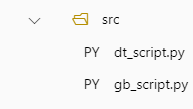

In [209]:
display.Image("Image/Image3.png")

### Infrastructure & Execution

Blue Deployment:

* The base model that we will deploy is referred to as the "blue" model by convention. After creation, this endpoint will be serving 100% of the traffic with the variant tagged as the blue version (the SVM model in this case).

* Once the server logic is implemented in the scoring script, we define the infrastructure we need to host and serve the model. Azure ML handles the resources needed to create the model server and attaches it to the endpoint with the name specified (note that the managed endpoint was created in the first step).

In [25]:
blue_deployment = ManagedOnlineDeployment(
    name="blue", # Name for the deployment
    endpoint_name=online_endpoint_name, # Name of the endpoint to deploy to
    model=registered_model_DT, # Registered model to deploy
    environment="AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest", # Environment to use for the deployment
    code_configuration=CodeConfiguration(
        code='./src',
        scoring_script='dt_script.py'# Name of the scoring script
    ),
    instance_type="Standard_E2S_v3",
    instance_count=1 # Number of instances to create
)

In [26]:
ml_client.online_deployments.begin_create_or_update(blue_deployment).result()

Check: endpoint german-credit-classifier-end-p exists
Uploading src (0.02 MBs): 100%|██████████| 16630/16630 [00:00<00:00, 216236.76it/s]




....................................................................

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'german-credit-classifier-end-p', 'type': 'Managed', 'name': 'blue', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/odidp:5e9d3499-2742-4096-88c0-21665b0a7675:d04c381a-741a-4fe9-b86f-6544fe429ce7?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/resourceGroups/GLMLPOs/providers/Microsoft.MachineLearningServices/workspaces/azureml/onlineEndpoints/german-credit-classifier-end-p/deployments/blue', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/comw6/code/Users/Tasnim_1717885446059', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object

### Testing

Invoking the specified endpoint and deployment with a sample input file named "sample-data_dt.json". It then prints the output of the invocation.

In [27]:
print(
    ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        deployment_name="blue",
        request_file="sample-data_dt.json"
    )
)

"[1, 1]"


### Canary Deployment

An important scenario in model deployment is the need to upgrade an existing baseline model to a newer version. A recommended approach to ensure a careful transition from the existing model ("blue") to the new version ("green") is through a canary deployment. This method involves directing a controlled portion of the live traffic to the upgraded endpoint. A/B testing is then performed to determine if the upgraded version performs better than the baseline on live data. The canary deployment process begins by diverting a small percentage of live traffic (typically between 1% and 5%) to the upgraded version and gradually increasing traffic if there are no errors.

#### Green Deployment

We use the second registered model as a "green" variant to be attached to the managed end point.

In [31]:
green_deployment = ManagedOnlineDeployment(
    name="green", # The name of the deployment
    endpoint_name=online_endpoint_name,
    model=registered_model_GB,
    environment="machine_learning_model_serving@latest",
    code_configuration=CodeConfiguration(
        code='./src',
        scoring_script='gb_script.py'# The name of the scoring script to run for the deployment
    ),
    instance_type="Standard_E2S_v3",
    instance_count=1
)

In [32]:
ml_client.online_deployments.begin_create_or_update(green_deployment).result()

Check: endpoint german-credit-classifier-end-p exists


.........

ManagedOnlineDeployment({'private_network_connection': None, 'package_model': False, 'provisioning_state': 'Succeeded', 'endpoint_name': 'german-credit-classifier-end-p', 'type': 'Managed', 'name': 'green', 'description': None, 'tags': {}, 'properties': {'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/odidp:5e9d3499-2742-4096-88c0-21665b0a7675:762181e5-a883-4301-b22a-86f8b4e7118f?api-version=2023-04-01-preview'}, 'print_as_yaml': False, 'id': '/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/resourceGroups/GLMLPOs/providers/Microsoft.MachineLearningServices/workspaces/azureml/onlineEndpoints/german-credit-classifier-end-p/deployments/green', 'Resource__source_path': '', 'base_path': '/mnt/batch/tasks/shared/LS_root/mounts/clusters/comw6/code/Users/Tasnim_1717885446059', 'creation_context': None, 'serialize': <msrest.serialization.Serializer obje

### Testing

Invoking the specified endpoint and deployment with a sample input file named "sample-data_gb.json". It then prints the output of the invocation.

In [33]:
print(
    ml_client.online_endpoints.invoke(
        endpoint_name=online_endpoint_name,
        deployment_name="green",
        request_file="sample-data_gb.json"
    )
)

"{\"predictions\": [1, 1]}"


### Safe rollout

Once the green variant is tested, we can define the traffic proportions to be allocated dynamically, gradually increasing the traffic seen by the green endpoint, eventually rolling over completely.

In [34]:
endpoint.traffic = {"blue": 99, "green": 1}

In [35]:
ml_client.begin_create_or_update(endpoint).result()

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://german-credit-classifier-end-p.eastus.inference.ml.azure.com/score', 'openapi_uri': 'https://german-credit-classifier-end-p.eastus.inference.ml.azure.com/swagger.json', 'name': 'german-credit-classifier-end-p', 'description': 'Model to predict german credit', 'tags': {}, 'properties': {'createdBy': 'Tasnim', 'createdAt': '2024-07-23T11:34:28.733261+0000', 'lastModifiedAt': '2024-07-23T11:34:28.733261+0000', 'azureml.onlineendpointid': '/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/resourcegroups/glmlpos/providers/microsoft.machinelearningservices/workspaces/azureml/onlineendpoints/german-credit-classifier-end-p', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/0d86e202-dfd4-4954-bdc4-ba82f5e270bd/providers/Microsoft.MachineLearningServices/locations/eastus/mfeOperationsStatus/oeidp:5e9d3499-2742-4096-88c0-21665b0a7675:bfb6e242-9408-442a-bf99-

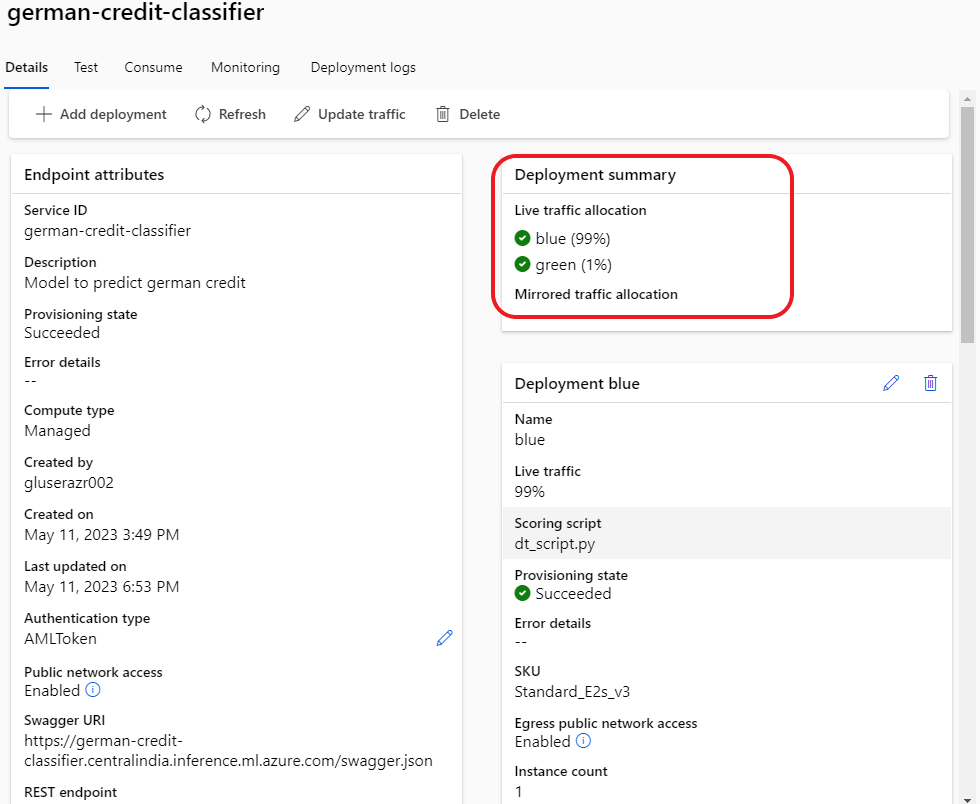

In [214]:
display.Image("Image/Image4.png")

### Clean up

To avoid costs incurred on idle endpoints during the testing phase, it is a good practise to delete end points. 

In [38]:
ml_client.online_endpoints.begin_delete(name=online_endpoint_name)

...............